In [1]:
# importing
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, " torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch
  import torchvision
  print(f"torchvision: {torch.__version__}")
  print(f"torchvision version : {torchvision.__version__}")


torch version:2.9.0+cu126
torchvision version:0.24.0+cu126


In [2]:
#continuing with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

#try to get torchinfo, installing it if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] couldn't find torchinfo... installing it")
  !pip install -q torchinfo
  from torchinfo import summary

# trying to import the going_modular directory, downlading it if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  #get the going_modular scripts
  print("[INFO] couldn't find going_modular or helper_functions scripts... downloading them from github.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] couldn't find torchinfo... installing it
[INFO] couldn't find going_modular or helper_functions scripts... downloading them from github.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 32.03 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# setting up directory paths to train and test images
train_dir = image_path/ "train"
test_dir = image_path / "test"


In [6]:
# preparing transforms for images
# creating image size (refernce from ViT paper)
IMG_SIZE = 224
# creating transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: { manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Turning images into Dataloader's
# Setting the batch Size

BATCH_SIZE = 32

import os
import shutil

# Check if the train_dir exists and is not empty. If not, re-download the data.
# This handles cases where the parent directory exists but the necessary subdirectories are missing,
# causing `download_data` to skip extraction.
if not os.path.exists(train_dir) or (os.path.exists(train_dir) and not os.listdir(train_dir)):
    print(f"[INFO] '{train_dir}' not found or is empty. Ensuring data is correctly set up.")

    # Remove the existing (potentially incomplete) data directory
    if os.path.exists(image_path):
        print(f"[INFO] Removing existing data directory: {image_path}")
        shutil.rmtree(image_path)

    # Re-download the data. The source is known, and destination is "pizza_steak_sushi".
    print(f"[INFO] Re-downloading data from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip to pizza_steak_sushi")
    _ = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")

# creating dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE

)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fb07b8e7ce0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
#visualizing a single image

# Getting a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# get a single image from batch
image, label = image_batch[0], label_batch[0]

#view the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

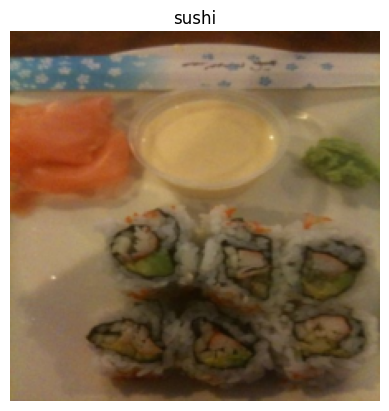

In [9]:
# plotting the image
plt.imshow(image.permute(1,2,0)) #rearranging colour dimensions(color,h,w)->(h,w,color_channels)
plt.title(class_names[label])
plt.axis(False);

In [10]:
# Replicating ViT paper for our own problem -> input will be images of pizza, steak, sushi and output  will be predicted labels of pizza, steak or sushi
#Calculating patch embedding inout and output shapes by hand.
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height *width)/patch_size**2)
print(f"Number of patches(N) with image height (H={height}), width(W = {width}) and patch size ( p = {patch_size}) : {number_of_patches}")


Number of patches(N) with image height (H=224), width(W = 224) and patch size ( p = 16) : 196


In [11]:
# Input shape(this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

#Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape(single 2D image flattened into patches): {embedding_layer_output_shape}")


Input shape (single 2D image): (224, 224, 3)
Output shape(single 2D image flattened into patches): (196, 768)


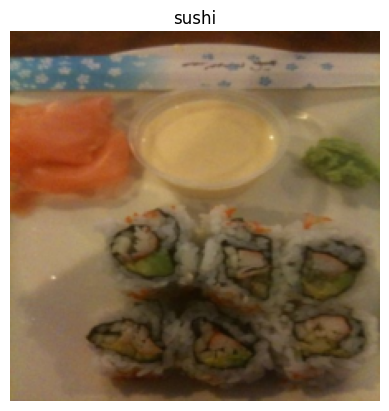

In [12]:
# Turning a single image into patches
# view single image
plt.imshow(image.permute(1,2,0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

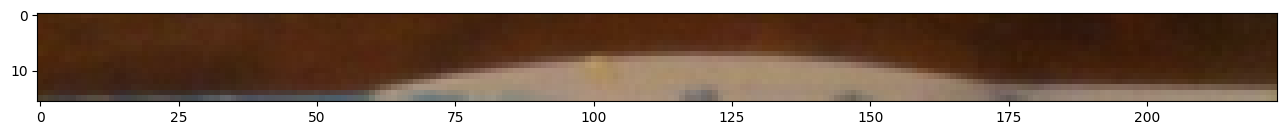

In [13]:
#Turning image into patches , trying to visualize the top row of patched pixels
# change image shape to be compatible with matplotlib

image_permuted = image.permute(1,2,0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:]);



Number of patches per row: 14.0 
 Patch size :16 pixels x 16 pixels


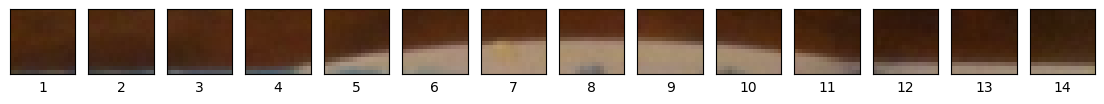

In [14]:
# we have our ffirst row now turning it into patches
# set up hyperparameters and make sure img_size and patch_size are compatible

img_size = 224
patch_size = 16
num_patches = img_size/ patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches} \n Patch size :{patch_size} pixels x {patch_size} pixels")

# create a series of subplots
fig, axs = plt.subplots(nrows = 1,
                        ncols = img_size // patch_size,
                        figsize = (num_patches, num_patches),
                        sharex = True,
                        sharey = True)

# iterate through number of patches in the top row
for i , patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch: patch+patch_size,:]); # keeping height index constant , altering width index
  axs[i].set_xlabel(i+1) #set the label
  axs[i].set_xticks([])
  axs[i].set_yticks([])


Number of patches per row: 14.0       
 Number of patches per column: 14.0        
 Total patches: 196.0        
 Patch size: 16 pixels x 16 pixels


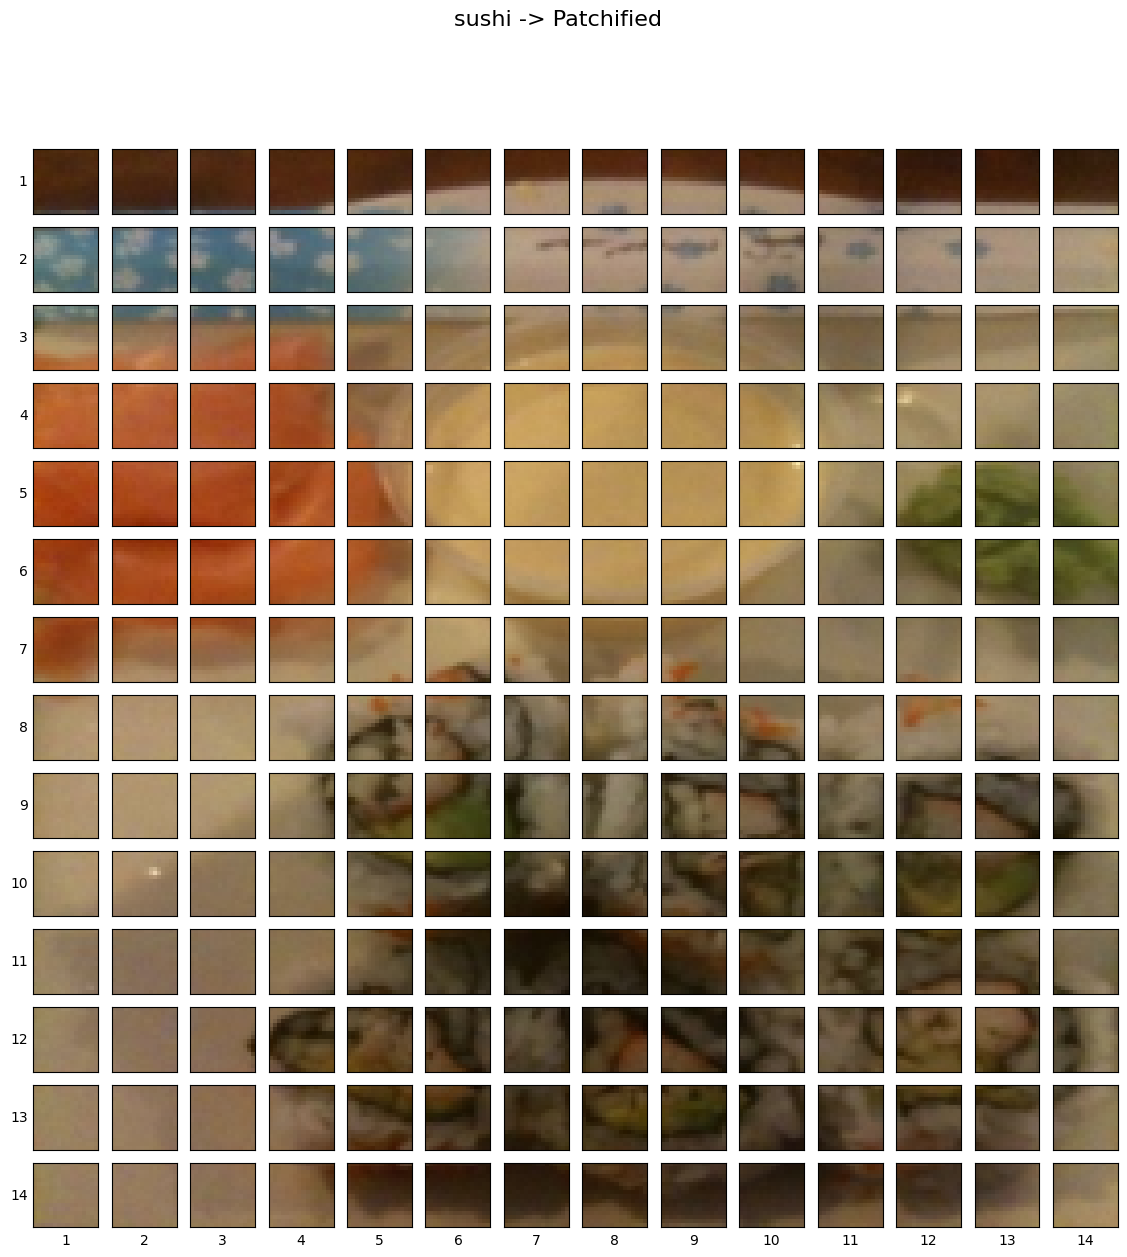

In [15]:
#setup hyperparameters and make sure imag_size and patch_size compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
       \n Number of patches per column: {num_patches}\
        \n Total patches: {num_patches*num_patches}\
        \n Patch size: {patch_size} pixels x {patch_size} pixels")

# creating a series of subplots
fig, axs = plt.subplots(nrows= img_size // patch_size, #need int not float
                        ncols = img_size // patch_size,
                        figsize = (num_patches, num_patches),
                        sharex = True,
                        sharey = True)

# Loop throught height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

      # plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
      axs[i, j].imshow(image_permuted[patch_height: patch_height + patch_size, # iterate through height
                                      patch_width: patch_width+patch_size, # iterate through width
                                      :]) # get all color channels

      axs[i, j].set_ylabel(i+1,
                           rotation="horizontal",
                           horizontalalignment = "right",
                           verticalalignment = "center")

      axs[i, j].set_xlabel(j+1)
      axs[i, j].set_xticks([])
      axs[i,j].set_yticks([])
      axs[i, j].label_outer()

# set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 16)
plt.show()



In [16]:
import torch
from torch import nn

# Turning the ViT patch embedding layer into a PyTorch module

# Create a class which sublclasses nn.Module

class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int = 3,
               patch_size :int = 16,
               embedding_dim : int = 768):
    super().__init__()
    #Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)

    # Create a layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim = 2, #only flatten the feature map dimensions into single vector
                              end_dim = 3)

  def forward(self, x):
    # Create assertions to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch_size: {patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # making sure the o/p shape has the right order
    return x_flattened.permute(0,2,1)

# Creating a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads:int = 12,
               attn_dropout:float = 0):
    super().__init__()

    # creating the Norm layer(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # Creating the Mulit-Head Attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True)

  # Create a forward() method to pass the data through the layers
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x,
                                         key = x,
                                         value = x,
                                         need_weights = False)
    return attn_output

In [17]:
set_seeds()

# creating an instance of patch embedding layer
patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim = 768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # adding an extra batch dimension on the 0th index
print(f"Output patch embedding shape:{patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape:torch.Size([1, 196, 768])


In [18]:
# Viewing the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} ->[batch_size, number_of_patches, embedding_dimension]")


tensor([[[-0.2332,  0.0453, -0.1040,  ...,  0.0967, -0.0974,  0.0600],
         [-0.2606,  0.0607, -0.0953,  ...,  0.0935, -0.0876,  0.0571],
         [-0.2571,  0.0706, -0.1171,  ...,  0.1303, -0.1063,  0.0360],
         ...,
         [-0.2745,  0.0205, -0.1321,  ...,  0.1757, -0.1011,  0.1285],
         [-0.4052,  0.1081, -0.1517,  ...,  0.3164, -0.1794,  0.1142],
         [-0.5632,  0.1053, -0.1437,  ...,  0.3965, -0.2449,  0.2157]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) ->[batch_size, number_of_patches, embedding_dimension]


In [19]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

#Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension(D)
class_token = nn.Parameter(torch.ones(batch_size,1, embedding_dimension),
                           requires_grad = True) # making sure the embedding is learnable


# seeing first 10 examples of class_token
print(class_token[:,:,: 10])

# print the class_token shape
print(f"Class token shape: {class_token.shape}")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768])


In [20]:
#adding the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim = 1) # concat on the first dimension

# print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embedding with class token prepended shape:{ patch_embedded_image_with_class_embedding.shape}")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2332,  0.0453, -0.1040,  ...,  0.0967, -0.0974,  0.0600],
         [-0.2606,  0.0607, -0.0953,  ...,  0.0935, -0.0876,  0.0571],
         ...,
         [-0.2745,  0.0205, -0.1321,  ...,  0.1757, -0.1011,  0.1285],
         [-0.4052,  0.1081, -0.1517,  ...,  0.3164, -0.1794,  0.1142],
         [-0.5632,  0.1053, -0.1437,  ...,  0.3965, -0.2449,  0.2157]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedding with class token prepended shape:torch.Size([1, 197, 768])


In [21]:
# view the sequence of patch embedding with prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2332,  0.0453, -0.1040,  ...,  0.0967, -0.0974,  0.0600],
          [-0.2606,  0.0607, -0.0953,  ...,  0.0935, -0.0876,  0.0571],
          ...,
          [-0.2745,  0.0205, -0.1321,  ...,  0.1757, -0.1011,  0.1285],
          [-0.4052,  0.1081, -0.1517,  ...,  0.3164, -0.1794,  0.1142],
          [-0.5632,  0.1053, -0.1437,  ...,  0.3965, -0.2449,  0.2157]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [22]:
# Calculate N(Number of patches)
number_of_patches = int(height*width / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

#Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad = True)

# showing the first 10 sequences and 10 positions embedding values and check the shape of the position embedding
print(position_embedding[:,:10,:10])
print(f"Position embedding shape: {position_embedding.shape}")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768])


In [23]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended, and positional embedding added shape: { patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7668, 1.0453, 0.8960,  ..., 1.0967, 0.9026, 1.0600],
         [0.7394, 1.0607, 0.9047,  ..., 1.0935, 0.9124, 1.0571],
         ...,
         [0.7255, 1.0205, 0.8679,  ..., 1.1757, 0.8989, 1.1285],
         [0.5948, 1.1081, 0.8483,  ..., 1.3164, 0.8206, 1.1142],
         [0.4368, 1.1053, 0.8563,  ..., 1.3965, 0.7551, 1.2157]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended, and positional embedding added shape: torch.Size([1, 197, 768])


# putting it all together from image to embedding


In [24]:
set_seeds()
# Set patch size
patch_size = 16

# print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Get image tensor and adding batch dimension
x = image.unsqueeze(0)
print(f"Imput image with batch dimension shape: {x.shape}")


# creating patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size = patch_size,
                                       embedding_dim = 768)

# Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

#Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1, embedding_dimension),
                           requires_grad = True) # making sure it's learnable

print(f"Class token shape: {class_token.shape}")

# prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int(height*width / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad = True) # making sure it's learnable

# adding position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Imput image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


Multi-Head Attention (MSA)


In [25]:
# Creating a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads:int = 12,
               attn_dropout:float = 0):
    super().__init__()

    # creating the Norm layer(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # Creating the Mulit-Head Attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True)

    # Create a forward() method to pass the data through the layers
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x,
                                           key = x,
                                           value = x,
                                           need_weights = False)
    return attn_output

In [26]:
# creating an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim = 768,
                                                             num_heads = 12)
# passing patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


Multilayer Perceptron(MLP)

In [27]:
# creating a class that inherits form nn.Module
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size:int = 3072,
               dropout:float = 0.1):
    super().__init__()

    #Create the Norm later(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    #Create the Multilayer perceptron(MLP) layer(s)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size,
                  out_features= embedding_dim),
        nn.Dropout(p = dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [28]:
# Creating an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

# pass outout of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")


Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


Creating transformer Encoder by combining our custom made layers

In [29]:
# Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim : int = 768,
               num_heads: int = 12,
               mlp_size: int = 3072,
               mlp_dropout: float = 0.1,
               attn_dropout: float = 0):
    super().__init__()

    # Creating MSA block
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    # creating MLP Block
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)

  def forward(self, x):
    # Creating residual connection for MSA block
    x = self.msa_block(x) + x

    # Create residual connection for MLP block
    x = self.mlp_block(x) + x

    return x


In [30]:
# Creating an dinstance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()
transformer_encoder_block

TransformerEncoderBlock(
  (msa_block): MultiheadSelfAttentionBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (mlp_block): MLPBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
  )
)

Putting it all together to create ViT

In [32]:
# ceating a ViT class that inherits from nn.Module
class ViT(nn.Module):
  def __init__(self,
               img_size: int = 224,
               in_channels: int = 3,
               patch_size: int = 16,
               num_transformer_layer: int = 12,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               num_heads : int = 12,
               attn_dropout: float = 0,
               mlp_dropout: float = 0.1,
               embedding_dropout: float = 0.1,
               num_classes: int = 1000):
    super().__init__()

    #Making the image size is divisible by the patcher size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size : {img_size}, patch size: {patch_size}"

    # Calulating number of patches
    self.num_patches = (img_size * img_size) // patch_size**2

    # creating learnable class embedding
    self.class_embedding = nn.Parameter(data = torch.randn(1,1, embedding_dim),
                                        requires_grad = True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dim),
                                           requires_grad = True)

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    # Create patch embedding later
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)

    # Create Transformer Encoder blocks
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim =  embedding_dim,
                                                                       num_heads = num_heads,
                                                                       mlp_size = mlp_size,
                                                                       mlp_dropout = mlp_dropout) for _ in range(num_transformer_layer)])

    # create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes)
    )


  def forward(self, x):
    # get batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    #Create patch embedding
    x = self.patch_embedding(x)

    #Concat class embedding and patch embedding
    x = torch.cat((class_token, x), dim = 1)

    #Add position embedding to patch embedding
    x = self.position_embedding + x

    #Run enbedding dropout
    x = self.embedding_dropout(x)

    #Pass patch , positon and class embedding through transformer encoder layer
    x = self.transformer_encoder(x)

    # Putting 0 index logit through classifier
    x = self.classifier(x[:,0])

    return x


In [33]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [34]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

Setting up training code for Our ViT model

In [35]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2245 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


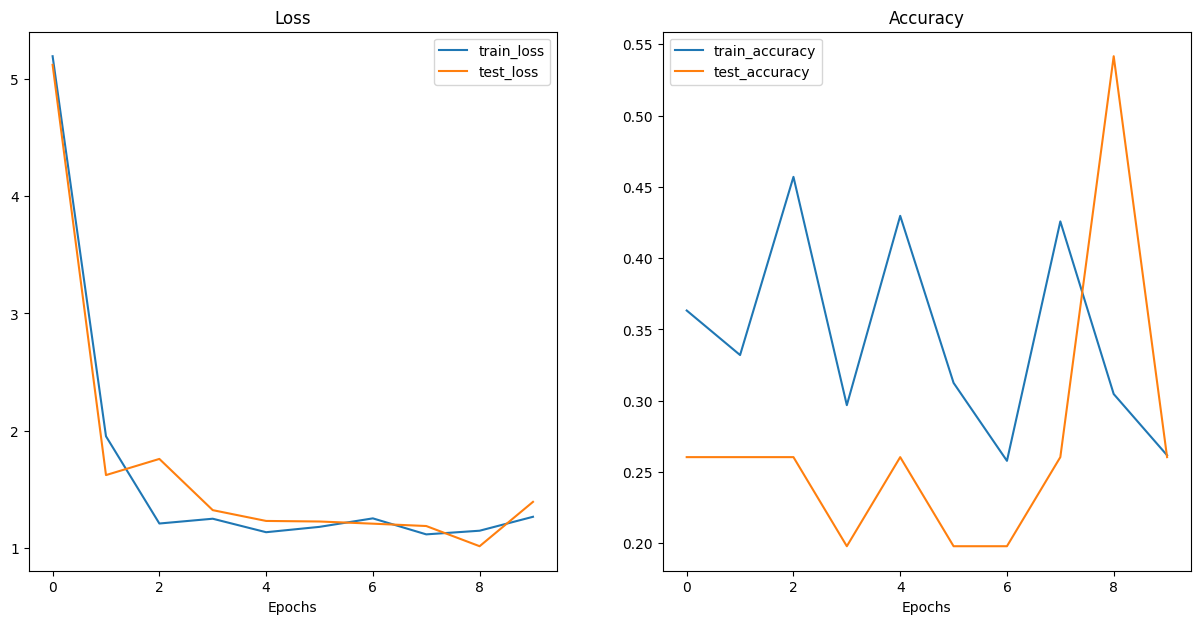

In [36]:
# plotting curves of out ViT model
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [ ]:
# using a pretrained ViT from torchvision.models

In [38]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.9.0+cu126
0.24.0+cu126


In [39]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:04<00:00, 78.6MB/s]


In [40]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [41]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [42]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [43]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [44]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


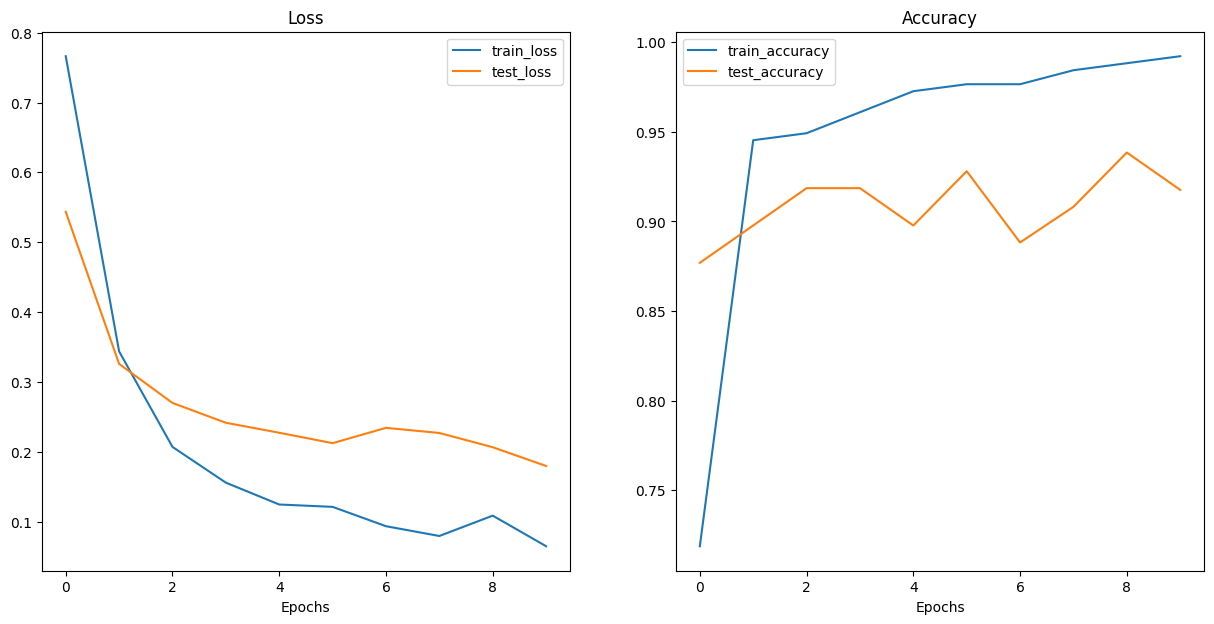

In [45]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [46]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [47]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


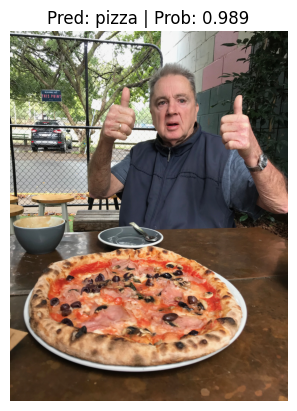

In [48]:
# making predictions

import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)